# Convolutional Neural Networks
Welcome to the practical assignment on convolutional neural networks (CNN) with a focus on freezing of gait (FOG) recognition. CNNs have revolutionized the field of computer vision by eliminating the need for manual feature engineering. Instead, these models can directly infer relevant features from raw input data. The seminal paper by Lecun et al. (1989) introduced the concept of convolutional neural networks, which has since seen a lot of successful applications in various domains, particularly in computer vision.

Deep CNNs, starting with AlexNet's groundbreaking win in the ImageNet competition in 2012, have been increasingly used for classifying raw input images or time series data. Fully connected neural networks or multilayer perceptrons (MLPs) face two major problems in handling large input data. Firstly, such networks contain several hundred thousand weights, which require a large training dataset to avoid overfitting. Secondly, fully connected networks ignore the topology of input data, and therefore, local correlations in data are lost. On the other hand, CNNs use convolutional layers, where filters are applied and slid over the input data, maintaining local correlation across the data. This property enables CNNs to learn features that are invariant across the time dimension, which is particularly useful for handling time series data. Moreover, CNNs require fewer parameters, allowing us to train deeper networks.

In this assignment, we focus on FOG recognition, a debilitating movement disorder that affects patients with Parkinson's disease. We aim to develop a CNN-based solution for accurate and efficient FOG recognition. For more information about the pathology of FOG, please refer to the following link: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7293393/ Interested students are also encouraged to read the AlexNet paper (https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) for further insights into CNNs.

### 0.1 Tensorflow-GPU Installation
To speed up our training time, we will be installing the GPU version of TensorFlow. This will allow us to leverage the power of the GPU to perform the computations required during training. In order to use the GPU, we will need to install a few additional packages and configure TensorFlow to use the GPU instead of the CPU.

In [ ]:
!pip install tensorflow-gpu==2.8.0

This will display information about the GPUs being used by your model during training. If you see GPU usage and memory usage, then your model is being trained with the GPU.

In [ ]:
import os

if 'COLAB_GPU' in os.environ:
    !nvidia-smi
else:
    print('Not running on GPU Environment')

## 1: Getting started
First, import all the packages that you will need during this assignment.

In [ ]:
from numpy.random import seed
import tensorflow as tf
import random
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, ReLU
from tensorflow.keras.activations import sigmoid
from prettytable import PrettyTable
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import LeaveOneGroupOut
import seaborn as sns

def setup_seed(seed):
     np.random.seed(seed)
     random.seed(seed)
     tf.random.set_seed(seed)

setup_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 1.1 Load the Dataset
Now that you have imported the library, our Neural Network will need something to learn from.
We will practice on the publicly available FOG dataset from:
https://pubmed.ncbi.nlm.nih.gov/35152881/

#### Dataset description
The training set contains 2541 segments, each 256 samples, containing the raw accelerometer information of the inertial-measurement unit (IMU) worn on the lumbar. (We do not use the other IMUs in this assignment. *You have the option to expand the project by incorporating additional IMUs.*)

We will start of by exploring the dataset with some python scripts.

#### Dataset exploration
Let's now load the dataset into memory and explore the class distribution.

**Please modify the `data_dir` variable in the code to the path of your dataset in your Google Drive.**

In [ ]:
drive.mount("/content/drive")
# data_dir = "/content/drive/MyDrive/kuleuven/AI&HEALTH/Project/all_data/"
data_dir = "/content/drive/MyDrive/all_data/"

# Load all files from a given directory
def load_data(fdir, input_dim, nseqlen):
    #fdir = data directory
    # imput_dim = número de columnas que tenemos en cuenta
    # nsqlen = window length
    files = os.listdir(fdir)

    inputs = np.zeros((len(files), nseqlen, input_dim))
    outputs = np.zeros((len(files), 1))
    fnames = []

    for i, imu_file in enumerate(files):
      #Generate ground truth labels
      if 'FOG' in imu_file:
          outputs[i, :] = int(1)
      else:
          outputs[i, :] = int(0)

      x = np.loadtxt(fdir+imu_file, delimiter=',') #load the data of a specific window
      #we only take the info of the sensors acelerometers located in the lumbar IMU
      inputs[i,:,:] = x[:,6:9] # index 6-8 for accelerometer on lumbar IMU
      #save the file names
      fnames.append(imu_file)

    return inputs, outputs, fnames

X, Y, fnames = load_data(data_dir, input_dim=3, nseqlen=256)

print("Dataset shape: " + str(X.shape))
print("Labels shape: " + str(Y.shape))
print("non-FOG windows: " + str(np.count_nonzero(Y == 0)))
print("FOG windows: " + str(np.count_nonzero(Y == 1)))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (2554, 256, 3)
Labels shape: (2554, 1)
non-FOG windows: 1909
FOG windows: 645


We can see that the dataset is quite unbalanced, i.e. there are three times as many non-FOG segments as FOG segments! This may make it more challenging to optimize and train our network.

Visualize the dataset using matplotlib. The data contains 2541 segments, each with 256 samples of 3-dimensional accelerometer information. Your goal is to build a model to fit this data. In other words, we want the classifier to classify each segment as either FOG or non-FOG.

<ipython-input-7-2891a8e1600e>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fig.suptitle('Label: %d' % Y[index], size=10)


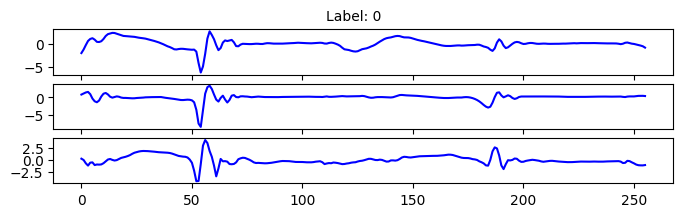

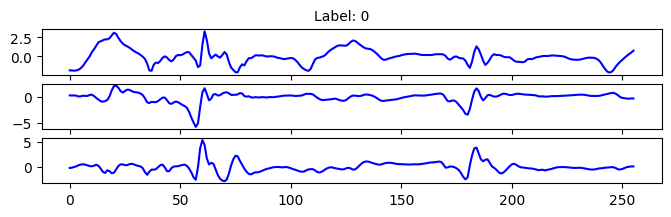

In [ ]:
# Visualize the first and fourth example

#Plot the value of the acelerometers of the first and 13th documents. All the frames and the 3 values corresponding to the acelerometers
def visualize(index):
  fig, axs = plt.subplots(3, 1, figsize=(8, 2))
  fig.suptitle('Label: %d' % Y[index], size=10)
  axs[0].plot(X[index,:,0], color='blue', label='x')
  axs[1].plot(X[index,:,1], color='blue', label='y')
  axs[2].plot(X[index,:,2], color='blue', label='z')

visualize(0)
visualize(12)

Let's normalize our data to bring all the values to a similar scale. This helps in improving the model's accuracy and stability during training. We'll use z-normalization, which involves scaling the data to have a mean of zero and a standard deviation of one.

<ipython-input-7-2891a8e1600e>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fig.suptitle('Label: %d' % Y[index], size=10)


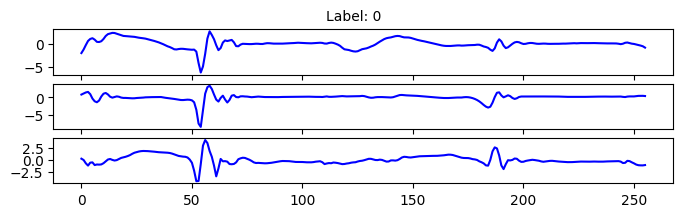

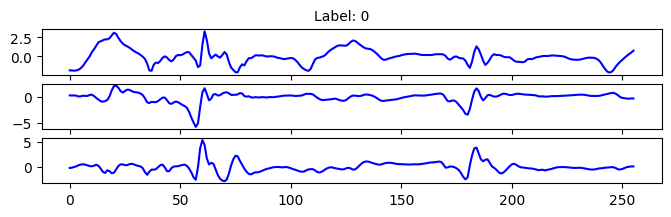

In [ ]:
def normalize(X):
    """Normalize the columns of X (zero mean, unit variance).
    Args:
        X (np array): data array.
    Returns:
        X_norm (np array): data array with normalized column values.

    """
    EPSILON = 1e-12  # to avoid divided by zero
    X = np.nan_to_num(X)
    X_norm = ((X - np.nanmean(X, axis=0))
             / (np.nanstd(X, axis=0) + EPSILON))
    return X_norm

X = np.array(list(map(normalize, X)))

visualize(0)
visualize(12)

Next, we print our the labels of the first ten examples.

In [ ]:
#Print the values of the GT labels
# 1--> FOG
# 0--> NON FOG
print("Labels (0-10): \n", Y[0:10])

Labels (0-10): 
 [[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]]


As you can see, our labels are encoded as integers: 1 for FOG and 0 for non-FOG. However, in some cases, it may be necessary to use one hot encoding instead.

Let's pause for a moment and think about what one hot encoding is and why it might be useful.

**Questions:**
- **What is one hot encoding? Why is it often used in machine learning?**
- **Do you think it's necessary to use it in our case of binary classification with FOG and non-FOG segments?**

## 2: Implement the neural network

### 2.1 Problem statement

Each machine learning project needs an unambiguous problem statement to clearly define the problem the model should solve. The input of our window-based model is an IMU signal $\mathbf{x} \in \mathbb{R}^{T \times C_{in}}$, $T$ is the number of samples in the window and $C_{in}$ is the number of features. The ground truth label $\mathbf{y} \in \mathbb{R}$ is the label. The goal of our deep learning model is to classify the feature vector $\mathbf{x}_i$ into its corresponding label $\mathbf{y}_i$ for all $i$ examples.

**Question: What is the $T$ and $C$ for our deep learning model?**

### 2.2 Exercise 1: Creating our CNN model

A 1D CNN layer can be represented mathematically using an equation. The layer takes an input vector $\mathbf{x}$ with dimensions $(256,3)$. The set of weights for this layer is represented as a matrix $\mathbf{W}$ with dimensions $(17,3,16)$ with 16 filters. Then the bias term is represented as a vector $\mathbf{b}$ with dimensions $(16,1)$.

To compute the output of the layer, we apply the following equation:

$\mathbf{a}^{[1]} = \sigma(\mathbf{W * x} + \mathbf{b})$

where the activation function $\sigma(\cdot)$ is applied element-wise to the linear combination of the input and weights with the bias term added.

**Question: What is the dimensions of the output matrix $\mathbf{a}^{[1]}$ in the above example? (with no padding and a stride of 1)**




In this section, we will implement a CNN model proposed from [this paper](https://jneuroengrehab.biomedcentral.com/articles/10.1186/s12984-022-00992-x#citeas) to classify the data. The CNN model consists of two 1D convolutional layers with ReLU activation, followed by a dropout layer to prevent overfitting. Each convolutional layer has 16 filters with (17,3) kernel size. The output of the convolutional layers is then passed through a max pooling layer and flattened before being fed into a fully connected layer with 10 nodes and ReLU activation. Finally, a single output node with sigmoid activation is used to output the binary classification label.

A visualization of the CNN model is:
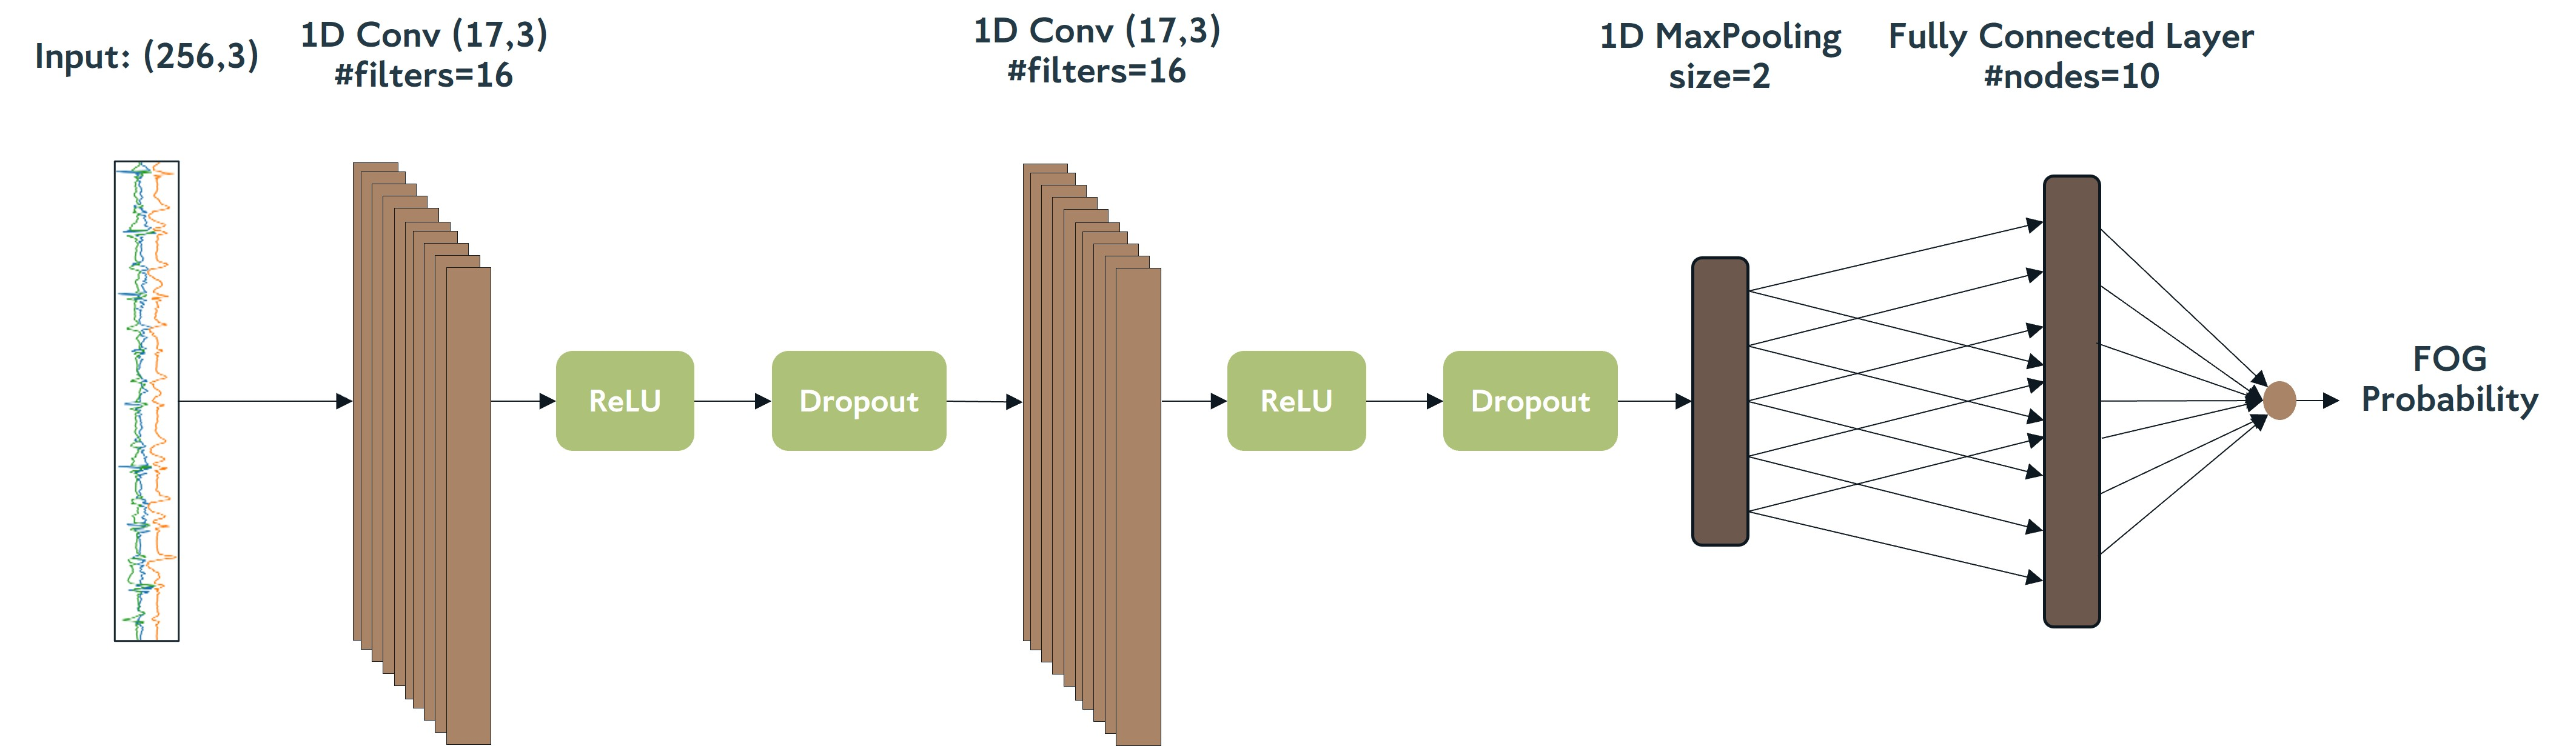

Now, we can start implement our model in python.

To define the CNN model using the Keras API, you can use the `Sequential` class to create a linear stack of layers. Then, you can add each layer using the `add` method. Here is an example code to define a CNN model with one convolutional layer with a ReLU activation function, the number of timestemps is 256 and the number of features is 3:

```python
model = Sequential()
model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_LEN, activation='relu', input_shape=(256, 3)))
```

The Keras layers API can be found in: https://www.tensorflow.org/api_docs/python/tf/keras/layers

Please fill in the missing parts of the function below to implement the CNN model:

In [ ]:
def CNN(n_timesteps, n_features, n_outputs):
    """Initialize CNN model.
    Args:
        n_timesteps (int): number of timesteps per example.
        n_features (int): number of features per example.
        n_outputs (int): number of output nodes.
    Returns:
        model (tf keras model): initialized model.
    """
    # TODO: Define the hyperparameters for the CNN model
    FILTERS = 16
    KERNEL_LEN = 17
    POOLSIZE = 2
    DROPOUTPROB = 0.5
    NEURONSDENSE = 10

    # TODO: Define the structure of the CNN model
    model = Sequential()
    model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_LEN, input_shape=(n_timesteps, n_features), activation='relu'))
    model.add(Dropout(DROPOUTPROB))
    model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_LEN, activation='relu'))
    model.add(Dropout(DROPOUTPROB))
    model.add(MaxPooling1D(pool_size=POOLSIZE))
    model.add(Flatten())
    model.add(Dense(NEURONSDENSE, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    return model

model = CNN(256, 3, 1)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 240, 16)           832       
                                                                 
 dropout (Dropout)           (None, 240, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 224, 16)           4368      
                                                                 
 dropout_1 (Dropout)         (None, 224, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 112, 16)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                        

Let's visualize the model architecture that you just implemented.

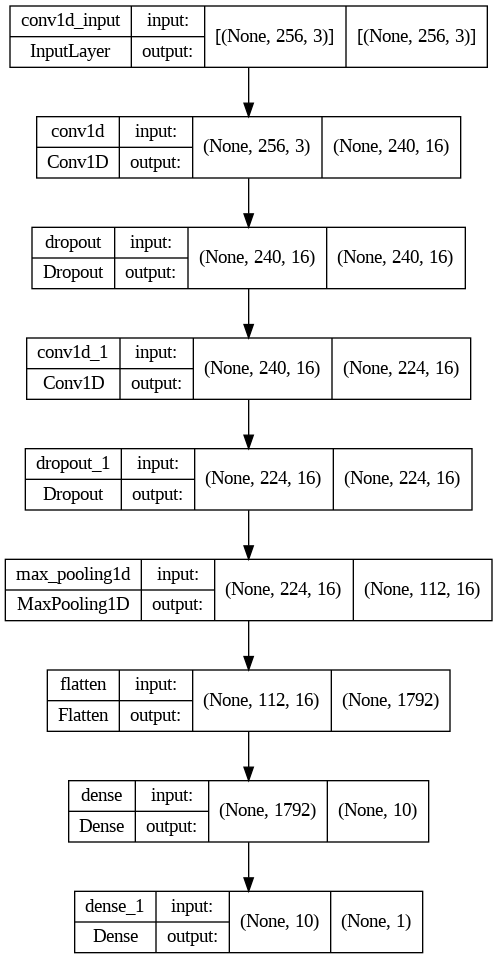

In [ ]:
# Plot the model architecture
plot_model(model, show_shapes=True)

To answer the previous question, you can print the shape of a specific layer in you model:

In [ ]:
conv_layer = model.layers[0] # get the first convolutional layer
weights, bias = conv_layer.get_weights() # get the weights and bias tensors
print("Shape of the weights tensor:", weights.shape)
print("Shape of the bias tensor:", bias.shape)

Shape of the weights tensor: (17, 3, 16)
Shape of the bias tensor: (16,)


For the first 1D CNN layer, the input tensor has the shape (num_timesteps, num_features), which is (256, 3). The weights tensor for the convolutional layer has the shape (kernel_size, num_features, num_filters), which is (17, 3, 16). The bias tensor has the shape (num_filters,), which is (16,). The output tensor from the convolutional layer has the shape (num_timesteps - kernel_size + 1, num_filters), which is (240, 16).

### 2.3 Exercise 2: Training and evaluating the CNN model

Splitting the dataset into training and testing sets is a fundamental step in machine learning. It allows us to train our model on a portion of the data and evaluate its performance on unseen data. A common way to split the dataset is using a 70-30 or an 80-20 ratio, where 70-80% of the data is allocated for training and the remaining 30-20% is allocated for testing.

However, the way we split the data can have a significant impact on our model's performance. If we allocate too little data for training, our model may not learn enough to generalize well to new data. On the other hand, if we allocate too much data for training, we may not have enough data to test our model's performance effectively.

from tensorflow.keras.model_selection import train_test_split

```python
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
```

Now, try to split up our dataset into training and testing sets using an 80-20 ratio, where 80% of the data is allocated for training and 20% is allocated for testing.

In [ ]:
TEST_PROP = 20/100
RANDOM_SEED = 42
# TODO: Split the data into 80% training and 20% testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_PROP, shuffle=True, random_state=42)

print("Training data shape: ", X_train.shape)
print("Training label shape: ", Y_train.shape)
print("Testing data shape: ", X_test.shape)
print("Testing label shape: ", Y_test.shape)

Training data shape:  (2043, 256, 3)
Training label shape:  (2043, 1)
Testing data shape:  (511, 256, 3)
Testing label shape:  (511, 1)


Before training the model, we need to compile it. This involves specifying the optimizer, loss function, and evaluation metric(s) to use during training. In this assignment, we can use the `adam` optimizer and `binary_crossentropy` loss function. We can also specify the `accuracy` metric to evaluate the model's performance.

Here's an example code to compile a model:

```python
# Compile the CNN model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
```

---

After we compile our CNN model, the next step is to train and evaluate it on the training and testing datasets, respectively. We will use the `fit` method of the model to train it on the training dataset. After training the model, we evaluate its performance on the testing dataset using the `evaluate` method of the model. The evaluate method returns the test loss and accuracy, which we can print out for analysis.

We can also visualize the training and testing accuracy and loss over the epochs using the `history` object returned by the `fit` method. This can help us identify whether the model is overfitting to the training data or not.

Here's an example code to train and evaluate the model with 50 epochs and a mini-batch size of 32:

```python
# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32)

# Evaluate the model on the testing dataset
loss, accuracy = model.evaluate(x_test, y_test)
```

Now, complete the following function to implement the training of our `CNN` model:



In [ ]:
def train(x_train, y_train, x_test, y_test, n_epochs = 50, batch_size = 32, learning_rate = 0.0001, class_weight=None, metrics = ['accuracy']):
    # TODO: Initialize the model
    model = CNN(x_train.shape[1], x_train.shape[2], y_train.shape[1])
    # TODO: Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    # TODO: Train the model
    history = model.fit(x_train, y_train,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        class_weight=class_weight)
    return history, model

history, model = train(X_train, Y_train, X_test, Y_test)

Epoch 1/50
64/64 [==============================] - 2s 22ms/step - loss: 0.6139 - accuracy: 0.7083 - val_loss: 0.5880 - val_accuracy: 0.7397
Epoch 2/50
64/64 [==============================] - 1s 19ms/step - loss: 0.5759 - accuracy: 0.7406 - val_loss: 0.5877 - val_accuracy: 0.7378
Epoch 3/50
64/64 [==============================] - 3s 41ms/step - loss: 0.5704 - accuracy: 0.7484 - val_loss: 0.5935 - val_accuracy: 0.7378
Epoch 4/50
64/64 [==============================] - 2s 24ms/step - loss: 0.5526 - accuracy: 0.7479 - val_loss: 0.5907 - val_accuracy: 0.7397
Epoch 5/50
64/64 [==============================] - 1s 19ms/step - loss: 0.5503 - accuracy: 0.7479 - val_loss: 0.5878 - val_accuracy: 0.7397
Epoch 6/50
64/64 [==============================] - 2s 26ms/step - loss: 0.5456 - accuracy: 0.7479 - val_loss: 0.5834 - val_accuracy: 0.7397
Epoch 7/50
64/64 [==============================] - 2s 30ms/step - loss: 0.5378 - accuracy: 0.7479 - val_loss: 0.5775 - val_accuracy: 0.7378
Epoch 8/50
64

Let's plot the training curve of our model. You can see that the accuracy is increasing for the training and testing data, while the loss for both are decreasing, which is a good sign for your model.

**Question: What is overfitting and underfitting? Can you tell from the learning curve whether the model is overfitting or underfitting on the training data?**

**Answer:** We can see that the accuracy in the training dataset kept increasing but in the test set it became stagnant. This means that the model was about to overfit, he was memorising minimal details of the training set that were lowering his capacity to generalise.

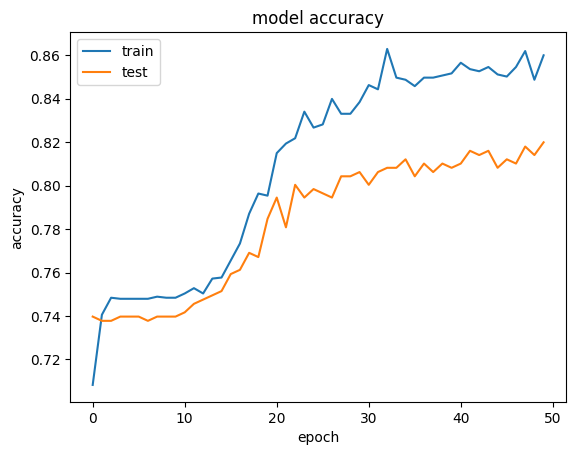

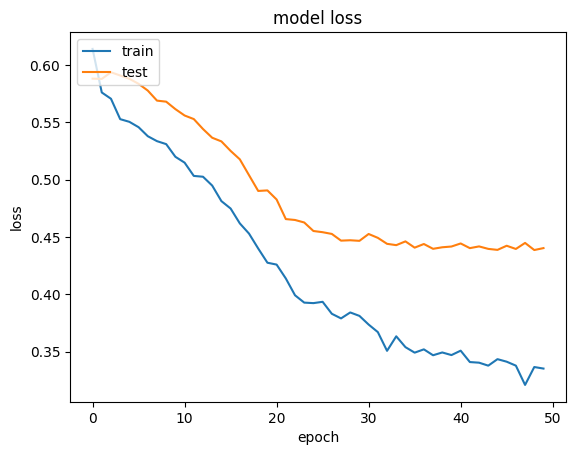

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We can also look at the classification report for our binary classification problem to have a deeper undertanding on the performance of our model. When evaluating the performance of our model, it's important to not only look at the overall accuracy but also the precision and recall of each class.

**Questions:**
- **What does precision and recall mean in the context of a binary classification problem?**
- **Answer:** $Precission = TP/(TP + FP)$ and $Recall= TP/(TP+FN)$. Recall=sensitivity means, between the positive (catalogues as FOG) how many do I identify as positive. Precission = Specifity = Positive Predictive value, how many of the identified as positive (FOG) , are actually positive.
- **What the is purpose of also reporting f1 scores?**
$F1= 2 (R*P)/(R+P) $ When there is unbalanced data the F1 score is very representative. Example: If I generate a model that always predicts positive, then the recall is 1, however the precision is low because among the predicted as + there is only a few that are actually positive.
- **Can you analyze the confusion matrix and explain why there is a high accuracy but a relatively low F1 score for the positive class?**

Confusion Matrix:
TN = 318, FP = 60, FN = 52, TP = 81

- Recall (FOG=1) = 81 / (81 + 52) = 0.61 --> 61%
- Recall (NONFOG = 0) = 318 / (318 + 60) = 0.84--> 84%
- Precision (FOG=1) = 81 / ( 81 + 60) *100 = 57%
- Precision (FOG = 0) = 318 / (318 + 52) *100 = 86%

The accuracy is measured as (TP + TN) / (TP+TN+FP+FN)  = (318 + 81) / (318 + 60 + 52 + 81) *100 = 78 % Which means that we are identifying correctcly 78% of the cases. However in this case  the F1 score of the positive classs is a lot more representative because the classes are unbalanced and in the Recall (FOG=1) and Precision (FOG=1) we can observe that only the 61% of the fogged labels are identified. And between the instances classified as FOG, only the 57% are actually FOG. That is represented by the F1 score.

In [ ]:
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred)

print('Confusion Matrix')
print(confusion_matrix(Y_test, Y_pred))
print('Classification Report')
print(classification_report(Y_test, Y_pred))

Confusion Matrix
[[354  24]
 [ 68  65]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.84      0.94      0.88       378
         1.0       0.73      0.49      0.59       133

    accuracy                           0.82       511
   macro avg       0.78      0.71      0.74       511
weighted avg       0.81      0.82      0.81       511





Based on the classification report, we can see that the f1 score for the positive class (class 1) is lower than the f1 score for the negative class (class 0). This suggests that the model may not be performing as well for class 1. One possible reason for this could be class imbalance in the dataset, where there are significantly fewer samples for class 1 compared to class 0. This could result in the model being biased towards class 0 and not performing as well for class 1.

In binary classification problems, it's common to report the F1 score for the positive class. This is because the positive class is typically the class of interest or the class that we want to correctly identify. By reporting the F1 score for the positive class, we can assess the model's ability to correctly identify this class while ignoring its performance on the negative class. This can be especially important if the negative class is much more prevalent than the positive class.

When training our model, we have set some hyperparameters, i.e., mini-batch size, learning rate, and the number of epochs, to specific values. These hyperparameters can significantly impact the performance of the model, and finding the optimal values can be challenging. Therefore, it is essential to experiment with different hyperparameters to achieve the best possible results.

**Questions:**
- **What is mini-batch size in deep learning and why is it important?**
- **How does the choice of mini-batch size affect the speed of training and the amount of memory required?**
Depends on the GPU, but in general, the smaller minibatch the more backpropagation we do per epoch. The more time it takes.
- **What are the advantages and disadvantages of using a mini-batch size of one (stochastic gradient descent) or a mini-batch size equals to the number of examples (batch gradient descent)?**
- **How does the choice of learning rate affect the speed of training and the quality of the learned model?**
Learning rate is a representative of how fast we learn. The higher learning rate, the faster we learn but we can overshoot the minimum.
- **What are some common problems that can arise when the number of epochs is too large or too small?**
Its prone to overfitting, we should implement a callback for early stopping.

### 2.4 Exercise 3: LOSO Cross Validation

Cross-validation is an essential technique in machine learning to evaluate the performance of a model and prevent overfitting. However, a single train-test split may not provide an accurate estimate of a model's performance, especially when dealing with limited data. Therefore, to address this issue, we can use the leave-one-subject-out (LOSO) cross-validation method.

The LOSO cross-validation is particularly useful when we want to evaluate our model's performance on subjects or participants that it has never seen before. This approach involves splitting the dataset into training and testing sets such that for each fold, we leave out one subject for testing and use the remaining subjects for training. We repeat this process for each subject so that each subject is left out exactly once for testing.

In this assignment, we will use the LOSO cross-validation to train and evaluate our model on the dataset. This technique will provide a better estimate of our model's performance as it will be evaluated on subjects that the model has never seen before.

Here is an example to implement LOSO to generate training and testing data in Keras using the `LeaveOneGroupOut` function from the scikit-learn library:

```python
from sklearn.model_selection import LeaveOneGroupOut
# Initialize the LeaveOneGroupOut cross-validator
logo = LeaveOneGroupOut()

# Loop over each fold of the LOSO cross-validation (assume our data is stored in X and Y)
for train_index, test_index in logo.split(X, Y, groups=groups):

    # Select the train and test data using the generated indices
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
```

**Question: What other methods could we use to evaluate our model? How would you do to create your dataset when using these methods?**

Now you can complete the following code to train and evaluate the model using the LOSO cross validation method for all subjects.

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras.optimizers import Adam

def LOSO_CV(x, y, n_epochs = 50, batch_size = 32, learning_rate = 0.0001, class_weight=None, metrics = ['accuracy']):
    # Initialize dictionarys to store visualization data
    history_all = {}

    # Initialize lists to store evaluation results
    acc_scores = []
    f1_scores = []

    # Initialize the LeaveOneGroupOut cross-validator
    logo = LeaveOneGroupOut()

    # Extract the subject numbers from the filenames
    groups = np.array([int(fname.split("_")[0][2:]) for fname in fnames])

    print(x.shape, y.shape, len(groups))
    # Loop over each subject
    for i, (train_index, test_index) in enumerate(logo.split(x, y, groups)):
        print('Training for subject %d' % (i+1))

        # TODO: Select training and testing data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        print("Training data shape: ", X_train.shape)
        print("Training label shape: ", y_train.shape)
        print('Non-FOG samples: ', np.count_nonzero(y_train == 0))
        print('FOG samples: ',np.count_nonzero(y_train == 1))
        print("\nTesting data shape: ", X_test.shape)
        print("Testing label shape: ", y_test.shape)
        print('Non-FOG samples: ', np.count_nonzero(y_test == 0))
        print('FOG samples: ', np.count_nonzero(y_test == 1))
        print("Class weights: ", class_weight)

        # TODO: Train the model
        history, model = train(X_train, y_train, X_test, y_test, n_epochs = n_epochs, batch_size = batch_size, learning_rate = learning_rate, class_weight=class_weight, metrics = metrics)
        # Save history for visualization
        history_all[i] = history

        # Evaluate the model on the held-out subject
        scores = model.evaluate(X_test, y_test, verbose=0)
        acc_scores.append(scores[1])

        y_pred = model.predict(X_test)
        y_pred = np.round(y_pred)

        print('Confusion Matrix')
        print(confusion_matrix(y_test, y_pred))
        print('Classification Report')
        print(classification_report(y_test, y_pred))

        f1_scores.append(f1_score(y_test, y_pred, pos_label=1))

    return history_all, acc_scores, f1_scores

history_all, acc_scores, f1_scores = LOSO_CV(X, Y)

(2554, 256, 3) (2554, 1) 2554
Training for subject 1
Training data shape:  (2230, 256, 3)
Training label shape:  (2230, 1)
Non-FOG samples:  1652
FOG samples:  578

Testing data shape:  (324, 256, 3)
Testing label shape:  (324, 1)
Non-FOG samples:  257
FOG samples:  67
Class weights:  None
Epoch 1/50
70/70 [==============================] - 2s 20ms/step - loss: 0.6401 - accuracy: 0.7013 - val_loss: 0.5680 - val_accuracy: 0.7901
Epoch 2/50
70/70 [==============================] - 1s 19ms/step - loss: 0.5961 - accuracy: 0.7283 - val_loss: 0.5703 - val_accuracy: 0.7901
Epoch 3/50
70/70 [==============================] - 1s 19ms/step - loss: 0.5889 - accuracy: 0.7341 - val_loss: 0.5761 - val_accuracy: 0.7932
Epoch 4/50
70/70 [==============================] - 2s 27ms/step - loss: 0.5658 - accuracy: 0.7399 - val_loss: 0.5718 - val_accuracy: 0.7932
Epoch 5/50
70/70 [==============================] - 2s 30ms/step - loss: 0.5604 - accuracy: 0.7430 - val_loss: 0.5594 - val_accuracy: 0.7932
Epoc

After training the model using the LOSO cross-validation method, we can evaluate the model's performance on unseen subjects. We can do this by computing and printing the average evaluation metrics across all subjects, including accuracy and F1-score.

In [ ]:
# create table
table = PrettyTable()
table.field_names = ["Subject", "Accuracy", "F1 Score"]

# add data rows
for i in range(len(acc_scores)):
    table.add_row([i+1, np.round(acc_scores[i],2), np.round(f1_scores[i],2)])

# add average row
avg_acc = sum(acc_scores) / len(acc_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)
table.add_row(["Average", np.round(avg_acc,2), np.round(avg_f1,2)])

# print table
print(table)

+---------+----------+----------+
| Subject | Accuracy | F1 Score |
+---------+----------+----------+
|    1    |   0.84   |   0.65   |
|    2    |   0.86   |   0.48   |
|    3    |   0.72   |   0.47   |
|    4    |   0.74   |   0.76   |
|    5    |   0.74   |   0.37   |
|    6    |   0.96   |   0.43   |
|    7    |   0.73   |   0.22   |
| Average |   0.8    |   0.48   |
+---------+----------+----------+


Throughout this notebook, we've delved into the process of building a binary classification model using a convolutional neural network to detect FOG on accelerometer data from a single IMU. The Keras framework, utilizing the TensorFlow backend, was used for training the model, while various metrics like accuracy, precision, recall, and F1 score were employed to evaluate its performance. However, it is important to note that the model is not perfect and still has room for improvement, as it may inaccurately classify non-FOG segments as FOG. Future work could explore the use of different network architectures and hyperparameters to further optimize the model's performance.

## 3: Improve the result

### 3.1 Exercise 4: Assigning class weights
As we mentioned before, our dataset is quite unbalanced with three times as many non-FOG segments as FOG segments. One way to solve this problem is with class weighting. This involves assigning higher weights to the minority class during training to give it more importance.

This can be done by setting `class_weight` parameter in the model fitting function: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

Now, let's retrain the models with a weight of 1 for non-FOG and 3 for FOG examples.

(You can also try out different class weights to see how they influence you result.)

In [ ]:
# TODO: Define the class weights
class_weight = {0: 1, 1: 3}
# TODO: Train and evaluate your model with LOSO
history_all, acc_scores, f1_scores= LOSO_CV(X, Y, class_weight = class_weight)
# create table
table = PrettyTable()
table.field_names = ["Subject", "Accuracy", "F1 Score"]

# add data rows
for i in range(len(acc_scores)):
    table.add_row([i+1, np.round(acc_scores[i],2), np.round(f1_scores[i],2)])

# add average row
avg_acc = sum(acc_scores) / len(acc_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)
table.add_row(["Average", np.round(avg_acc,2), np.round(avg_f1,2)])

# print table
print(table)

(2554, 256, 3) (2554, 1) 2554
Training for subject 1
Training data shape:  (2230, 256, 3)
Training label shape:  (2230, 1)
Non-FOG samples:  1652
FOG samples:  578

Testing data shape:  (324, 256, 3)
Testing label shape:  (324, 1)
Non-FOG samples:  257
FOG samples:  67
Class weights:  {0: 1, 1: 3}
Epoch 1/50
70/70 [==============================] - 2s 21ms/step - loss: 1.1588 - accuracy: 0.4910 - val_loss: 0.6872 - val_accuracy: 0.5772
Epoch 2/50
70/70 [==============================] - 1s 18ms/step - loss: 1.0716 - accuracy: 0.5318 - val_loss: 0.6893 - val_accuracy: 0.5093
Epoch 3/50
70/70 [==============================] - 1s 18ms/step - loss: 1.0744 - accuracy: 0.5108 - val_loss: 0.7060 - val_accuracy: 0.3611
Epoch 4/50
70/70 [==============================] - 1s 19ms/step - loss: 1.0580 - accuracy: 0.4726 - val_loss: 0.7033 - val_accuracy: 0.3580
Epoch 5/50
70/70 [==============================] - 1s 19ms/step - loss: 1.0421 - accuracy: 0.5049 - val_loss: 0.7013 - val_accuracy: 0.3

You can observe that by assigning higher weights to the minority class, the model learns to pay more attention to correctly classifying instances from that class. This is because the higher weight assigned to the minority class increases its importance during training, thereby reducing the bias towards the majority class. As a result, the model becomes more balanced and better at capturing patterns from both classes, leading to an improved overall performance.

**Question:**
- **How does assigning higher weights to the minority class help in improving model performance?**
- **What does it means to assign class weights? How does the weight influence the training process?**

# Optional Project

Throughout this assignment, you've delved into implementing a 1D CNN model for FOG detection, covering various aspects from data preprocessing to hyperparameter tuning and cross-validation. While your efforts have yielded valuable insights, it's clear that there's room for improvement in model performance.

For those keen to delve deeper, consider embarking on an optional project where you can push the boundaries of FOG detection. One avenue is to explore the implementation of a 2D CNN model, expanding beyond the singular lumbar IMU to incorporate data from multiple IMUs. Additionally, you might explore alternative techniques such as the LSTM model.

This optional project invites you to apply the knowledge acquired in this assignment, as well as from your broader learning experience, to uncover new avenues and approaches for enhancing FOG detection. Whether drawing from lecture materials or other modules, the goal is to foster exploration and innovation in this critical domain.

# Signal Correlation Of Different Sensors

We find it interesting to add the signal information of other IMU sensors. But the more signals we add the bigger our model would be, higher training and prediction time etc. For that reason, we can start by calculating the correlation of the different sensor signals/patient to see if we can identify a pattern. The signals that have a high correlation between them, wont provide much information since they are very simmilar, however signals with a lower correlation provide much more information since the model focuses on a broader field to calculate when FOG occurs.

- We can explore the Correlation of the sensors in different parts of the body. Hight correlation implies that if we add this sensor to the model, the real information will be approximately the same. However if the correlation is low, implies that the information of this IMU sensor can contribute with a lot of information to the performance of the model.
- Once we have this results we could choose which sensors contribute the most and add the features of those sensors. The input X will be (2554,256, N) with N the number of features we added. And apply a 1DConv to it. See how the performance of the model varies when using more sensors.
- An LSTM approach, linearising the results and given the info of one window, training it to predict the next output can also be interesting.


In [ ]:
# Load all files from a given directory
from google.colab import drive
drive.mount("/content/drive")
# data_dir = "/content/drive/MyDrive/kuleuven/AI&HEALTH/Project/all_data/"
data_dir = "/content/drive/MyDrive/all_data/"

def load_data(fdir, input_dim, nseqlen):
    #fdir = data directory
    # imput_dim = número de columnas que tenemos en cuenta
    # nsqlen = window length
    files = os.listdir(fdir)

    inputs = np.zeros((len(files), nseqlen, input_dim))
    outputs = np.zeros((len(files), 1))
    fnames = []

    for i, imu_file in enumerate(files):
      #Generate ground truth labels
      if 'FOG' in imu_file:
          outputs[i, :] = int(1)
      else:
          outputs[i, :] = int(0)

      x = np.loadtxt(fdir+imu_file, delimiter=',') #load the data of a specific window
      # Sensor Locations:
      # 1-6 Chest IMU
      # 7 -12 Lumbar IMU
      # 13- 18 Left Ancle IMU
      # 19 -24 Right Ancle IMU
      # 25-30 Left Foot IMU
      # 31-36 Right Foot IMU
      inputs[i,:,:] = x[:,:] # index 6-8 for accelerometer on lumbar IMU
      #save the file names
      fnames.append(imu_file)

    return inputs, outputs, fnames

X, Y, fnames = load_data(data_dir, input_dim=36, nseqlen=256)
print("Dataset shape: " + str(X.shape))
print("Labels shape: " + str(Y.shape))
print("non-FOG windows: " + str(np.count_nonzero(Y == 0)))
print("FOG windows: " + str(np.count_nonzero(Y == 1)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (2554, 256, 36)
Labels shape: (2554, 1)
non-FOG windows: 1909
FOG windows: 645


In [ ]:
import numpy as np
import pandas as pd
from prettytable import PrettyTable
import seaborn as sns
import matplotlib.pyplot as plt

def reshape_and_correlate(data):
    # Reshaping the array to 2D
    reshaped_data = data.reshape(-1, data.shape[2])

    # Convert to a pandas DataFrame to facilitate correlation calculations
    df = pd.DataFrame(reshaped_data)

    # Calculating the correlation matrix
    correlation_matrix = df.corr()

    return correlation_matrix

def plot_heatmap(correlation_matrix):
    # Calculate the absolute value of the correlation matrix
    abs_corr_matrix = np.abs(correlation_matrix)

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(abs_corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
    plt.title('Heatmap of Absolute Correlation Between Sensors')
    plt.show()

def plot_filtered_heatmap(correlation_matrix):
    # Calculate the absolute value of the correlation matrix
    abs_corr_matrix = np.abs(correlation_matrix)

    # Filter out values less than 0.5
    abs_corr_matrix[abs_corr_matrix < 0.5] = 0

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    # Using 'viridis' but you could change to another colormap if you prefer different colors
    sns.heatmap(abs_corr_matrix, annot=False, cmap='viridis', linewidths=.5, cbar_kws={'label': 'Correlation Strength'})
    plt.title('Heatmap of Absolute Correlation Between Sensors (Filtered)')
    # Set color for zero values to white
    plt.show()

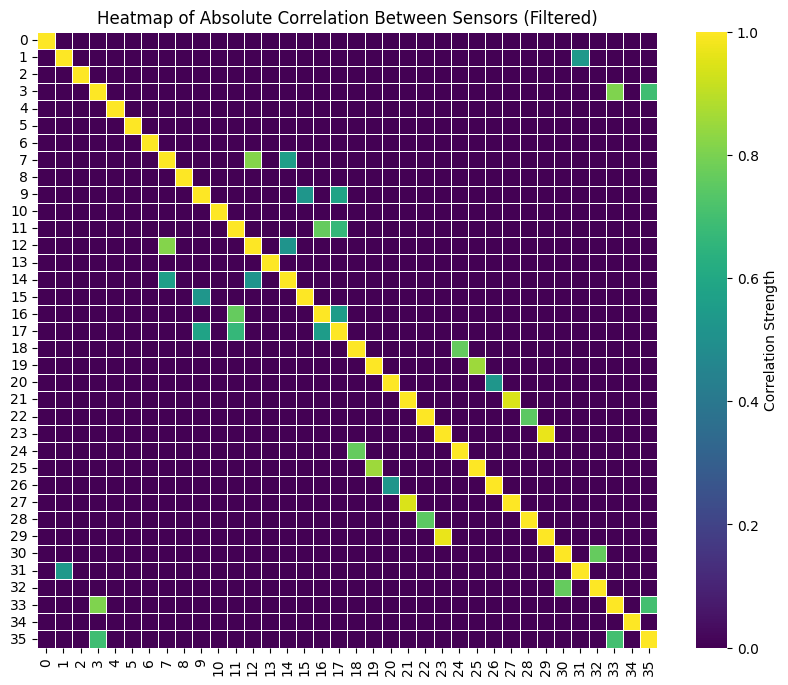

In [ ]:
data = X
correlation_matrix = reshape_and_correlate(data)
plot_filtered_heatmap(correlation_matrix)

Resumen:
- Columnas 0-5:   Chest IMU
- Columnas 6-11:  Lumbar IMU
- Columnas 12-17: Left Ancle IMU
- Columnas 18-23: Right Ancle IMU
- Columnas 24-29: Left Foot IMU
- Columnas 30-35: Right Foof IMU

In the heatmap, there is a strong correlation (1-1) between the accelerometers and the gyroscopes of the sensors (18-23) and (24-29), which suggests a correlation between the Right Ankle IMU and the Left Foot IMU. I am unsure if this is coherent or not, it seems strange as they are different feet. It is also interesting to observe the correlation of the accelerometer on the z-axis of the chest IMU with the gyroscopes placed on the Right Foot, or the correlation between (12-17) and (6-11). I am also surprised not to see more correlation between the accelerometers and the gyroscopes within the same sensor.

Given these results, and to avoid having a very large model, I consider it would be a good idea to use as input for our model the sensors of both feet, chest, and lumbar since they are not correlated with each other. Given that there is not much angular mobility in the lumbar or chest, we could, for example, consider as input the features corresponding to the chest accelerometers, lumbar accelerometers, and (accelerometers + gyroscopes) of both ankles, i.e., X.shape = (2554, 256, 18). And then apply a 1D convolution with n_features = 18. What do you think about this alternative? Before proceeding, I would like to know your opinion on this.



In [ ]:
from google.colab import drive
drive.mount("/content/drive")
# data_dir = "/content/drive/MyDrive/kuleuven/AI&HEALTH/Project/all_data/"
data_dir = "/content/drive/MyDrive/all_data/"

# Load all files from a given directory
def load_data(fdir, input_dim, nseqlen):
    #fdir = data directory
    # imput_dim = número de columnas que tenemos en cuenta
    # nsqlen = window length
    files = os.listdir(fdir)

    inputs = np.zeros((len(files), nseqlen, input_dim))
    outputs = np.zeros((len(files), 1))
    fnames = []

    for i, imu_file in enumerate(files):
      #Generate ground truth labels
      if 'FOG' in imu_file:
          outputs[i, :] = int(1)
      else:
          outputs[i, :] = int(0)

      x = np.loadtxt(fdir+imu_file, delimiter=',') #load the data of a specific window
      #We take into account the Acelerometers located in the chest 0-2, Acelerometers of the lumbar 6-8
      # giroscopes and acelerometers of both foot. 24-29 and 30-35
      column_indices = np.hstack((np.arange(0, 3), np.arange(6, 9), np.arange(24, 30), np.arange(30, 36)))
      inputs[i, :, :] = x[:, column_indices]
      #save the file names
      fnames.append(imu_file)

    return inputs, outputs, fnames

X, Y, fnames = load_data(data_dir, input_dim=18, nseqlen=256)
X = np.array(list(map(normalize, X)))
print("Dataset shape: " + str(X.shape))
print("Labels shape: " + str(Y.shape))
print("non-FOG windows: " + str(np.count_nonzero(Y == 0)))
print("FOG windows: " + str(np.count_nonzero(Y == 1)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (2554, 256, 18)
Labels shape: (2554, 1)
non-FOG windows: 1909
FOG windows: 645


In [ ]:
# reimport some libraries
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras.optimizers import Adam

def CNN(n_timesteps, n_features, n_outputs):
    """Initialize CNN model.
    Args:
        n_timesteps (int): number of timesteps per example.
        n_features (int): number of features per example.
        n_outputs (int): number of output nodes.
    Returns:
        model (tf keras model): initialized model.
    """
    # TODO: Define the hyperparameters for the CNN model
    FILTERS = 16
    KERNEL_LEN = 17
    POOLSIZE = 2
    DROPOUTPROB = 0.5
    NEURONSDENSE = 10

    # TODO: Define the structure of the CNN model
    model = Sequential()
    model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_LEN, input_shape=(n_timesteps, n_features), activation='relu'))
    model.add(Dropout(DROPOUTPROB))
    model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_LEN, activation='relu'))
    model.add(Dropout(DROPOUTPROB))
    model.add(MaxPooling1D(pool_size=POOLSIZE))
    model.add(Flatten())
    model.add(Dense(NEURONSDENSE, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    return model
def train(x_train, y_train, x_test, y_test, n_epochs = 50, batch_size = 32, learning_rate = 0.0001, class_weight=None, metrics = ['accuracy']):
    # TODO: Initialize the model
    model = CNN(x_train.shape[1], x_train.shape[2], y_train.shape[1])
    # TODO: Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    # TODO: Train the model
    history = model.fit(x_train, y_train,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        class_weight=class_weight)
    return history, model
def LOSO_CV(x, y, n_epochs = 50, batch_size = 32, learning_rate = 0.0001, class_weight=None, metrics = ['accuracy']):
    # Initialize dictionarys to store visualization data
    history_all = {}

    # Initialize lists to store evaluation results
    acc_scores = []
    f1_scores = []

    # Initialize the LeaveOneGroupOut cross-validator
    logo = LeaveOneGroupOut()

    # Extract the subject numbers from the filenames
    groups = np.array([int(fname.split("_")[0][2:]) for fname in fnames])

    print(x.shape, y.shape, len(groups))
    # Loop over each subject
    for i, (train_index, test_index) in enumerate(logo.split(x, y, groups)):
        print('Training for subject %d' % (i+1))

        # TODO: Select training and testing data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        print("Training data shape: ", X_train.shape)
        print("Training label shape: ", y_train.shape)
        print('Non-FOG samples: ', np.count_nonzero(y_train == 0))
        print('FOG samples: ',np.count_nonzero(y_train == 1))
        print("\nTesting data shape: ", X_test.shape)
        print("Testing label shape: ", y_test.shape)
        print('Non-FOG samples: ', np.count_nonzero(y_test == 0))
        print('FOG samples: ', np.count_nonzero(y_test == 1))
        print("Class weights: ", class_weight)

        # TODO: Train the model
        history, model = train(X_train, y_train, X_test, y_test, n_epochs = n_epochs, batch_size = batch_size, learning_rate = learning_rate, class_weight=class_weight, metrics = metrics)
        # Save history for visualization
        history_all[i] = history

        # Evaluate the model on the held-out subject
        scores = model.evaluate(X_test, y_test, verbose=0)
        acc_scores.append(scores[1])

        y_pred = model.predict(X_test)
        y_pred = np.round(y_pred)

        print('Confusion Matrix')
        print(confusion_matrix(y_test, y_pred))
        print('Classification Report')
        print(classification_report(y_test, y_pred))

        f1_scores.append(f1_score(y_test, y_pred, pos_label=1))

    return history_all, acc_scores, f1_scores



In [ ]:
# TODO: Define the class weights
class_weight = {0: 1, 1: 3}
# TODO: Train and evaluate your model with LOSO
history_all, acc_scores, f1_scores= LOSO_CV(x=X, y=Y, class_weight=class_weight)
# create table
table = PrettyTable()
table.field_names = ["Subject", "Accuracy", "F1 Score"]

# add data rows
for i in range(len(acc_scores)):
    table.add_row([i+1, np.round(acc_scores[i],2), np.round(f1_scores[i],2)])

# add average row
avg_acc = sum(acc_scores) / len(acc_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)
table.add_row(["Average", np.round(avg_acc,2), np.round(avg_f1,2)])

# print table
print(table)

(2554, 256, 18) (2554, 1) 2554
Training for subject 1
Training data shape:  (2230, 256, 18)
Training label shape:  (2230, 1)
Non-FOG samples:  1652
FOG samples:  578

Testing data shape:  (324, 256, 18)
Testing label shape:  (324, 1)
Non-FOG samples:  257
FOG samples:  67
Class weights:  {0: 1, 1: 3}
Epoch 1/50
70/70 [==============================] - 4s 49ms/step - loss: 1.0802 - accuracy: 0.5278 - val_loss: 0.6984 - val_accuracy: 0.4444
Epoch 2/50
70/70 [==============================] - 2s 34ms/step - loss: 1.0604 - accuracy: 0.4883 - val_loss: 0.6940 - val_accuracy: 0.4907
Epoch 3/50
70/70 [==============================] - 2s 28ms/step - loss: 1.0585 - accuracy: 0.4816 - val_loss: 0.6911 - val_accuracy: 0.4815
Epoch 4/50
70/70 [==============================] - 2s 28ms/step - loss: 1.0416 - accuracy: 0.5354 - val_loss: 0.6870 - val_accuracy: 0.5556
Epoch 5/50
70/70 [==============================] - 3s 41ms/step - loss: 1.0453 - accuracy: 0.5063 - val_loss: 0.6884 - val_accuracy: 

# Parkinson's Disease Signal Analysis (Frequency Based Feature Extraction)

In this notebook, we are performing a signal analysis that is specifically designed to help in the diagnosis and study of Parkinson's disease. The dataset used here consists of sensor readings with a shape of `(2554, 256, 36)`, which represents 2554 windows of 256 timesteps each. Each window corresponds to 2 seconds, indicating that the sampling rate of the sensors is 128 Hz.

After reshaping the data, we have a matrix of `(256x2554, 36)`, meaning we have 256x2554 timesteps and in each timestep, there is a signal from 36 sensors. The processing steps are as follows:

1. **DC Component Removal**: For each sensor (column in the matrix), we first filter out the DC component. This is a crucial step to focus on the changes in the signal rather than its absolute value.

2. **Windowing**: The data is then segmented into overlapping windows using a Hamming window to mitigate spectral leakage. This windowing technique is vital to preserve the integrity of the data across the edges of each window. We use a window size of 276 with 10 samples of zero padding at both the start and end of each window, and a stride of 256, ensuring some overlap between consecutive windows for continuity in analysis.

3. **Fourier Transform**: We apply the Discrete Fourier Transform (DFT) to each window to transform the data from the time domain to the frequency domain. This transformation allows us to analyze the frequency components of the signal, which are crucial for identifying Parkinson's disease-related patterns.

4. **Frequency Filtering**: Post transformation, we filter the frequencies to focus on the range from 3 to 7 Hz, which are particularly relevant to Parkinson's disease symptoms such as tremors. We utilize a resolution of 0.5 Hz to finely dissect the frequency spectrum and isolate the most indicative frequencies.

5. **Amplitude Summation**: The amplitudes of these filtered frequencies are then summed across all sensors for each discrete frequency, providing a comprehensive view of the signal strength at each frequency point.

6. **Heatmap Visualization**: Finally, the summed amplitudes are plotted in a heatmap. This visualization represents the intensity of each frequency across the different windows and can serve as a valuable input for convolutional neural networks for further classification or diagnostic analysis.

This approach not only highlights the critical frequencies associated with Parkinson's disease but also prepares the dataset for advanced machine learning applications, potentially aiding in automated diagnosis systems.

In [ ]:
# Load all files from a given directory
from google.colab import drive
drive.mount("/content/drive")
# data_dir = "/content/drive/MyDrive/kuleuven/AI&HEALTH/Project/all_data/"
data_dir = "/content/drive/MyDrive/AI&HEALTH/Project/all_data/"

def load_data(fdir, input_dim, nseqlen):
    #fdir = data directory
    # imput_dim = número de columnas que tenemos en cuenta
    # nsqlen = window length
    files = os.listdir(fdir)

    inputs = np.zeros((len(files), nseqlen, input_dim))
    outputs = np.zeros((len(files), 1))
    fnames = []

    for i, imu_file in enumerate(files):
      #Generate ground truth labels
      if 'FOG' in imu_file:
          outputs[i, :] = int(1)
      else:
          outputs[i, :] = int(0)

      x = np.loadtxt(fdir+imu_file, delimiter=',') #load the data of a specific window
      #We take into account the Acelerometers located in the chest 0-2, Acelerometers of the lumbar 6-8
      # giroscopes and acelerometers of both foot. 24-29 and 30-35
      column_indices = np.hstack((np.arange(0, 3), np.arange(6, 9), np.arange(24, 30), np.arange(30, 36)))
      inputs[i, :, :] = x[:, column_indices]

      #save the file names
      fnames.append(imu_file)

    return inputs, outputs, fnames
def normalize(X):
    """Normalize the columns of X (zero mean, unit variance).
    Args:
        X (np array): data array.
    Returns:
        X_norm (np array): data array with normalized column values.

    """
    EPSILON = 1e-12  # to avoid divided by zero
    X = np.nan_to_num(X)
    X_norm = ((X - np.nanmean(X, axis=0))
             / (np.nanstd(X, axis=0) + EPSILON))
    return X_norm

X, Y, fnames = load_data(data_dir, input_dim=18, nseqlen=256)
X = np.array(list(map(normalize, X)))
print("Dataset shape: " + str(X.shape))
print("Labels shape: " + str(Y.shape))
print("non-FOG windows: " + str(np.count_nonzero(Y == 0)))
print("FOG windows: " + str(np.count_nonzero(Y == 1)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (2554, 256, 18)
Labels shape: (2554, 1)
non-FOG windows: 1909
FOG windows: 645


In [ ]:
START_FREQUENCY = 2
END_FREQUENCY = 8
STEP_FREQUENCY = 0.05
#number of frequencies we are taking into account
NUMFREQ = len(np.arange(START_FREQUENCY, END_FREQUENCY, STEP_FREQUENCY))
NUMSAMPLES_GRAPH = 50

Frequency data: (2554, 120)


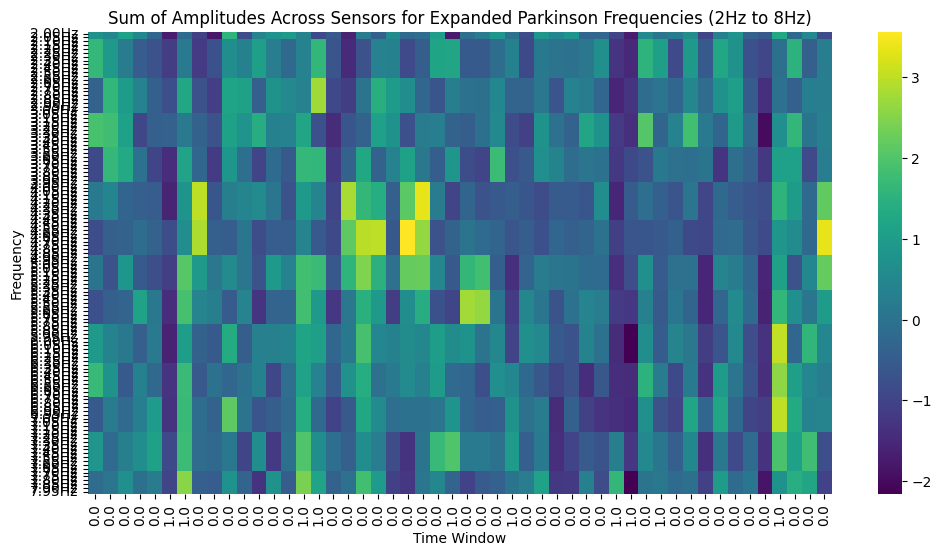

In [ ]:
class ParkinsonSignalProcessorNumpy:
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate

    def dc_removal(self, data):
        return data - np.mean(data, axis=0)

    def apply_hamming_and_fft(self, data, frame_size, stride_size, zero_padding=10, min_freq = 2, max_freq = 10.25, step_freq = 0.25):
        data_padded = np.pad(data, (zero_padding, zero_padding), 'constant')
        num_frames = (len(data_padded) - frame_size) // stride_size + 1
        # Ajustar el rango de frecuencias y la resolución
        freqs_of_interest = np.arange(min_freq, max_freq, step_freq)
        freq_indices = np.round(freqs_of_interest * frame_size / self.sample_rate).astype(int)
        result = np.zeros((num_frames, len(freqs_of_interest)))

        for i in range(num_frames):
            start = i * stride_size
            end = start + frame_size
            windowed_data = data_padded[start:end] * np.hamming(frame_size)
            fft_result = np.fft.rfft(windowed_data)
            result[i, :] = np.abs(fft_result[freq_indices])

        return result
def normalize(X):
    EPSILON = 1e-12
    X = np.nan_to_num(X)
    X_norm = ((X - np.nanmean(X, axis=0)) / (np.nanstd(X, axis=0) + EPSILON))
    return X_norm

# Suponemos que X y Y están definidos previamente
data_reshaped = X.reshape(-1, X.shape[2])
processor = ParkinsonSignalProcessorNumpy(sample_rate=128)
labels = Y.flatten()
frequency_data = np.zeros((len(labels), NUMFREQ))  # Ajustar el tamaño según el nuevo rango de frecuencia

for column in range(data_reshaped.shape[1]):
    dc_removed = processor.dc_removal(data_reshaped[:, column])
    amplitudes = processor.apply_hamming_and_fft(dc_removed, 276, 256,min_freq=START_FREQUENCY,max_freq = END_FREQUENCY, step_freq = STEP_FREQUENCY)
    frequency_data += amplitudes

frequency_data_normalized = normalize(frequency_data)

print(f'Frequency data: {frequency_data.shape}')
# Seleccionar 50 muestras para la visualización

indices = np.linspace(0, len(labels) - 1, NUMSAMPLES_GRAPH, dtype=int)
sampled_labels = labels[indices]
sampled_data = frequency_data_normalized[indices, :]

# Visualizar los resultados usando un heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sampled_data.T, cmap='viridis', annot=False, fmt=".2f",
            xticklabels=sampled_labels,
            yticklabels=[f"{freq:.2f}Hz" for freq in np.arange(START_FREQUENCY, END_FREQUENCY, STEP_FREQUENCY)])
plt.title(f'Sum of Amplitudes Across Sensors for Expanded Parkinson Frequencies ({START_FREQUENCY}Hz to {END_FREQUENCY}Hz)')
plt.xlabel('Time Window')
plt.ylabel('Frequency')
plt.show()

This can be used as an input for another CNN

In [ ]:
def CNN(n_timesteps, n_features, n_outputs):
    """Initialize CNN model.
    Args:
        n_timesteps (int): number of timesteps per example.
        n_features (int): number of features per example.
        n_outputs (int): number of output nodes.
    Returns:
        model (tf keras model): initialized model.
    """
    # TODO: Define the hyperparameters for the CNN model
    FILTERS = 25
    KERNEL_LEN = 15
    POOLSIZE = 2
    DROPOUTPROB = 0.5
    NEURONSDENSE = 10

    # TODO: Define the structure of the CNN model
    model = Sequential()
    model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_LEN, input_shape=(n_timesteps, n_features), activation='relu'))
    model.add(Dropout(DROPOUTPROB))
    model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_LEN, activation='relu'))
    model.add(Dropout(DROPOUTPROB))
    model.add(MaxPooling1D(pool_size=POOLSIZE))
    model.add(Flatten())
    model.add(Dense(NEURONSDENSE, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    return model


def LOSO_CV_freq(x, y, n_epochs = 50, batch_size = 32, learning_rate = 0.0001, class_weight=None, metrics = ['accuracy'],START_FREQUENCY = 2,END_FREQUENCY = 10.25,STEP_FREQUENCY = 0.25 ):
    # Initialize dictionarys to store visualization data
    history_all = {}

    # Initialize lists to store evaluation results
    acc_scores = []
    f1_scores = []

    # Initialize the LeaveOneGroupOut cross-validator
    logo = LeaveOneGroupOut()

    # Extract the subject numbers from the filenames
    groups = np.array([int(fname.split("_")[0][2:]) for fname in fnames])

    print(x.shape, y.shape, len(groups))
    # Loop over each subject
    for i, (train_index, test_index) in enumerate(logo.split(x, y, groups)):
        print('Training for subject %d' % (i+1))

        # TODO: Select training and testing data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #MODIFICATIONS GO HERE
        #number of frequencies we are taking into account
        NUMFREQ = len(np.arange(START_FREQUENCY, END_FREQUENCY, STEP_FREQUENCY))
        print(f'Num_freq: {NUMFREQ}')
        #Training data
        X_train_freq = np.zeros((X_train.shape[0], NUMFREQ))
        print(X_train_freq.shape)
        X_train = X_train.reshape(-1, X.shape[2])
        processor = ParkinsonSignalProcessorNumpy(sample_rate=128)
        #y_train = y_train.flatten()

        for column in range(X_train.shape[1]):
            dc_removed = processor.dc_removal(X_train[:, column])
            amplitudes = processor.apply_hamming_and_fft(dc_removed, 276, 256, min_freq = START_FREQUENCY, max_freq = END_FREQUENCY, step_freq = STEP_FREQUENCY)
            X_train_freq += amplitudes

        X_train_freq = normalize(X_train_freq)
        X_train_freq = np.expand_dims(X_train_freq, axis=2)

        #Test data
        X_test_freq = np.zeros((X_test.shape[0], NUMFREQ))
        X_test = X_test.reshape(-1, X.shape[2])
        processor = ParkinsonSignalProcessorNumpy(sample_rate=128)
        #y_test = y_test.flatten()

        for column in range(X_test.shape[1]):
            dc_removed = processor.dc_removal(X_test[:, column])
            amplitudes = processor.apply_hamming_and_fft(dc_removed, 276, 256, min_freq = START_FREQUENCY, max_freq = END_FREQUENCY, step_freq = STEP_FREQUENCY)
            X_test_freq += amplitudes

        X_test_freq = normalize(X_test_freq)
        X_test_freq = np.expand_dims(X_test_freq, axis=2)

        #END OF MODIFICATIONS
        print("Training data shape: ", X_train_freq.shape)
        print("Training label shape: ", y_train.shape)
        print('Non-FOG samples: ', np.count_nonzero(y_train == 0))
        print('FOG samples: ',np.count_nonzero(y_train == 1))
        print("\nTesting data shape: ", X_test_freq.shape)
        print("Testing label shape: ", y_test.shape)
        print('Non-FOG samples: ', np.count_nonzero(y_test == 0))
        print('FOG samples: ', np.count_nonzero(y_test == 1))
        print("Class weights: ", class_weight)

        #COMENTED IT OUT

        # TODO: Train the model
        history, model = train(X_train_freq, y_train, X_test_freq, y_test, n_epochs = n_epochs, batch_size = batch_size, learning_rate = learning_rate, class_weight=class_weight, metrics = metrics)
        # Save history for visualization
        history_all[i] = history

        # Evaluate the model on the held-out subject
        scores = model.evaluate(X_test_freq, y_test, verbose=0)
        acc_scores.append(scores[1])

        y_pred = model.predict(X_test_freq)
        y_pred = np.round(y_pred)

        print('Confusion Matrix')
        print(confusion_matrix(y_test, y_pred))
        print('Classification Report')
        print(classification_report(y_test, y_pred))

        f1_scores.append(f1_score(y_test, y_pred, pos_label=1))

    return history_all, acc_scores, f1_scores

In [ ]:
# TODO: Define the class weights
class_weight = {0: 1, 1: 3}
# TODO: Train and evaluate your model with LOSO
history_all, acc_scores, f1_scores= LOSO_CV_freq(x=X, y=Y, class_weight=class_weight,START_FREQUENCY =START_FREQUENCY ,END_FREQUENCY = END_FREQUENCY,STEP_FREQUENCY =STEP_FREQUENCY)
# create table
table = PrettyTable()
table.field_names = ["Subject", "Accuracy", "F1 Score"]

# add data rows
for i in range(len(acc_scores)):
    table.add_row([i+1, np.round(acc_scores[i],2), np.round(f1_scores[i],2)])

# add average row
avg_acc = sum(acc_scores) / len(acc_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)
table.add_row(["Average", np.round(avg_acc,2), np.round(avg_f1,2)])

# print table
print(table)

(2554, 256, 18) (2554, 1) 2554
Training for subject 1
Num_freq: 120
(2230, 120)
Training data shape:  (2230, 120, 1)
Training label shape:  (2230, 1)
Non-FOG samples:  1652
FOG samples:  578

Testing data shape:  (324, 120, 1)
Testing label shape:  (324, 1)
Non-FOG samples:  257
FOG samples:  67
Class weights:  {0: 1, 1: 3}
Epoch 1/50
70/70 [==============================] - 5s 52ms/step - loss: 1.0494 - accuracy: 0.5148 - val_loss: 0.7198 - val_accuracy: 0.3457
Epoch 2/50
70/70 [==============================] - 2s 29ms/step - loss: 1.0037 - accuracy: 0.5341 - val_loss: 0.7130 - val_accuracy: 0.4599
Epoch 3/50
70/70 [==============================] - 2s 24ms/step - loss: 0.9702 - accuracy: 0.6081 - val_loss: 0.6906 - val_accuracy: 0.5648
Epoch 4/50
70/70 [==============================] - 1s 16ms/step - loss: 0.9471 - accuracy: 0.6372 - val_loss: 0.6367 - val_accuracy: 0.6944
Epoch 5/50
70/70 [==============================] - 1s 16ms/step - loss: 0.9335 - accuracy: 0.6646 - val_loss: